<a href="https://colab.research.google.com/github/AnnaDS/Stock_forecast/blob/main/forecasting/Supervised_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM and XGboost models

### Connect to Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.listdir('drive/MyDrive/stock_forecast/forecasting/lib')



['models.py', 'get_data.py', 'data_prep.py', '__pycache__']

### Import data and required functions

In [3]:
from drive.MyDrive.stock_forecast.forecasting.lib.data_prep import prepare_data_feat_step
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

stock_price=pd.read_csv('drive/MyDrive/stock_forecast/data/TSLA.csv')
stock_price.index=pd.DatetimeIndex(stock_price['Unnamed: 0'])

### Prepare Training and testing data

In [4]:
training_days=int(len(stock_price)*0.75)
#test orecast on last 30 business days
training_days=len(stock_price.index[:-30])
n_lags=5
step=0
target_col='Close'
extra_features=[]
X_train, y_train, X_test, real_stock_price, sc_extra=prepare_data_feat_step(stock_price, training_days, n_lags, step, target_col, extra_features)


### Create and train LSTM model

In [ ]:
from drive.MyDrive.stock_forecast.forecasting.lib.models import rnn_model, lstm_horizon_model
y_train = y_train.reshape(-1, 1)
lstm_model = lstm_horizon_model(X_train, y_train)


In [ ]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with TensorBoard callback
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/50
17/17 [==============================] - 13s 142ms/step - loss: 0.1497 - val_loss: 0.0658
Epoch 2/50
17/17 [==============================] - 0s 30ms/step - loss: 0.0387 - val_loss: 0.0109
Epoch 3/50
17/17 [==============================] - 1s 31ms/step - loss: 0.0235 - val_loss: 0.0163
Epoch 4/50
17/17 [==============================] - 0s 28ms/step - loss: 0.0163 - val_loss: 0.0084
Epoch 5/50
17/17 [==============================] - 0s 29ms/step - loss: 0.0086 - val_loss: 0.0011
Epoch 6/50
17/17 [==============================] - 0s 30ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 7/50
17/17 [==============================] - 0s 28ms/step - loss: 0.0082 - val_loss: 0.0011
Epoch 8/50
17/17 [==============================] - 0s 27ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 9/50
17/17 [==============================] - 0s 28ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 10/50
17/17 [==============================] - 1s 31ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 1

Test predicting single value

In [ ]:
# To predict a single value
def predict_single_value(model, X_input):
    X_input = np.expand_dims(X_input, axis=0)  # Adjust shape to (1, 5, 2)
    prediction = model.predict(X_input)
    return prediction

# Example usage:
X_sample = X_train[0]  # Example input, a single sample from X_train
predicted_value = predict_single_value(lstm_model, X_sample)
sc=sc_extra[target_col]
print(sc.inverse_transform(predicted_value))

1/1 [==============================] - 2s 2s/step
[[245.3642]]


### Predict test using LSTM model

1/1 [==============================] - 0s 49ms/step


<Axes: >

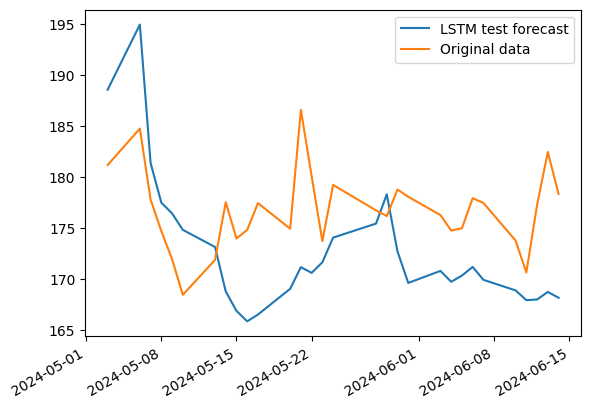

In [ ]:
#predict test with trained model
#
y_pred=lstm_model.predict(X_test)
#get the right scaller
sc=sc_extra[target_col]
y_pred=sc.inverse_transform(y_pred)

y_pred_df=pd.DataFrame({'LSTM test forecast':y_pred.reshape(-1),
                        'Original data':real_stock_price[target_col].values},
                        index=real_stock_price.index.values)

y_pred_df.plot()


In [ ]:
# Calculate MAPE
def calculate_mape(actual, predicted):
    mask = actual != 0
    return (np.abs(actual[mask] - predicted[mask]) / actual[mask]).mean() * 100

mape_lstm_test = calculate_mape(y_pred_df['Original data'], y_pred_df['LSTM test forecast'])

print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm_test:.2f}%")


Mean Absolute Percentage Error (MAPE): 3.71%


### Create autoregressive model for the all predicted horizon of test data

In [ ]:
def autoregressive_forecast(model, X_test, n_forecast_steps):
    """
    Make autoregressive forecasts using the trained LSTM model.

    Args:
        model (Sequential): Trained LSTM model.
        X_test (np.ndarray): Initial test data.
        n_forecast_steps (int): Number of steps to forecast into the future.

    Returns:
        np.ndarray: Forecasted values.
    """
    predictions = []
    input_sequence = X_test[-1, :, :].copy()

    for _ in range(n_forecast_steps):
        #print(input_sequence[np.newaxis, :, :])
        prediction = model.predict(input_sequence[np.newaxis, :, :])[0, 0]
        predictions.append(prediction)
        # Append the new prediction and remove the oldest value to maintain the sequence length
        input_sequence = np.append(input_sequence[1:], [[prediction] + list(input_sequence[-1, 1:])], axis=0)

    return np.array(predictions)

def autoregressive_forecast(model, initial_input, n_steps, sc_target):
    forecast = []
    current_input = initial_input.copy()
    n_features = current_input.shape[1]

    for _ in range(n_steps):
        # Make a prediction
        pred = model.predict(current_input.reshape(1, n_lags, -1))
        forecast.append(pred[0, 0])

        # Update the input for the next prediction
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = pred[0, 0]  # Update Close price

        # For Volume, you can use the last known volume or an average
        # Here, we're using the last known volume
        # Update extra features if any
        for i in range(1, n_features):
            # For extra features, use the last known value
            current_input[-1, i] = current_input[-2, i]

    # Inverse transform the forecast
    forecast = sc_target.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()
# Make autoregressive forecast
#n_forecast_steps = 30  # Number of steps to forecast
#predictions = autoregressive_forecast(lstm_model, X_test, n_forecast_steps)

n_forecast_steps = len(X_test)  # Number of steps to forecast
#lstm_test_predictions = autoregressive_forecast(lstm_model, X_train, n_forecast_steps)
# Get the last sequence from X_test as initial input
initial_input = X_train[-1]
#For the features, that are unknown for future periods,
#we simply use the last known feature values.
#We could also use an average feature values or implement a separate forecasting method for them if needed.
lstm_test_predictions = autoregressive_forecast(lstm_model, initial_input, n_forecast_steps,sc_extra[target_col] )


1/1 [==============================] - 0s 26ms/step


In [ ]:
# Inverse transform the predictions to get the actual values
#lstm_test_predictions = sc_extra[target_col].inverse_transform(lstm_test_predictions.reshape(-1, 1)).flatten()

In [ ]:
#Getting date range for a testing period
train_ind=stock_price.iloc[n_lags:training_days].index
start_date = train_ind[-1]

# Generate a range of 30 business days starting from the last date in the stock_price index
business_days = pd.bdate_range(start=start_date, periods=n_forecast_steps)

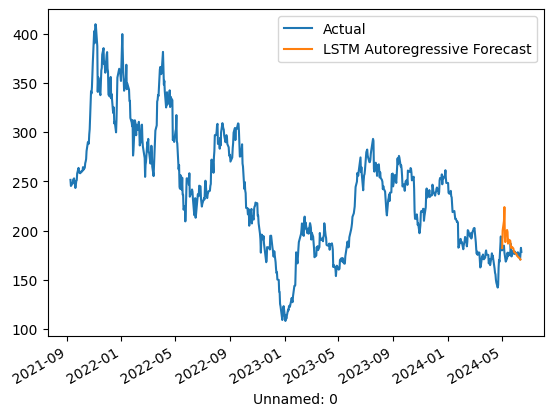

In [ ]:

stock_price['Close'].plot(label='Actual')
pd.Series(lstm_test_predictions, index=business_days).plot(label='LSTM Autoregressive Forecast').plot()
plt.legend()
plt.show()

Mean Absolute Percentage Error (MAPE): 6.14%


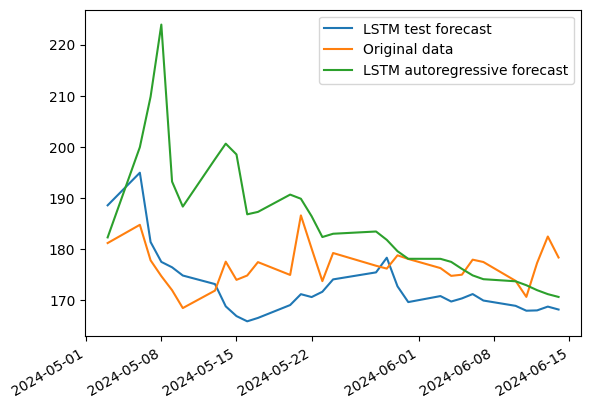

In [ ]:
y_pred_df['LSTM autoregressive forecast']=lstm_test_predictions
y_pred_df.plot()

mape_lstm_autoreg = calculate_mape(y_pred_df['Original data'], y_pred_df['LSTM autoregressive forecast'])

print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm_autoreg:.2f}%")


#### 1 and 7 days forecasted MAPE

In [ ]:
# 1-day forecast MAPE
mape_1day = calculate_mape(y_pred_df['Original data'][1:].values, y_pred_df['LSTM autoregressive forecast'][:-1].values)
print(f"1-day forecast MAPE: {mape_1day:.2f}%")

# 7-day forecast MAPE (assuming daily data)
mape_7day = calculate_mape(y_pred_df['Original data'][7:].values, y_pred_df['LSTM autoregressive forecast'][:-7].values)
print(f"7-day forecast MAPE: {mape_7day:.2f}%")


1-day forecast MAPE: 6.51%
7-day forecast MAPE: 7.34%


### Use XGBoost model

In [ ]:
#Get and train on scaled data
X_train_df=pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
col_vals=[target_col]+extra_features
cols_res=[]
for c in col_vals:
    for i in range(1, n_lags+1,1):
        cols_res.append(f'{c}_{n_lags-i+1}')
X_train_df.columns=cols_res
#train_ind=stock_price.iloc[n_lags:training_days].index

X_train_df.index=train_ind
y_train_df=pd.Series(y_train.squeeze(-1),index=train_ind)

X_test_df=pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_test_df.columns=cols_res

In [ ]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train_df,y_train_df )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred=xgb_model.predict(X_test_df)
sc=sc_extra[target_col]
xgb_pred=sc.inverse_transform(xgb_pred.reshape(len(xgb_pred),1))


<Axes: >

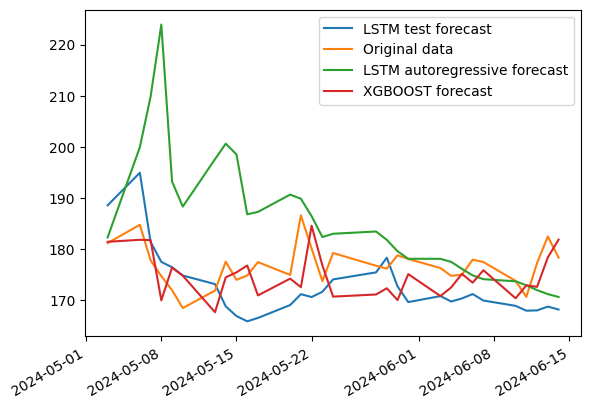

In [ ]:
#xgb_pred_df=pd.DataFrame({'xgb_forecast':xgb_pred.reshape(-1),
#                        'Original data':real_stock_price[target_col].values},
#                        index=real_stock_price.index.values)
y_pred_df['XGBOOST forecast']=xgb_pred.reshape(-1)

y_pred_df.plot()

In [ ]:
mape_xgb_test = calculate_mape(y_pred_df['Original data'], y_pred_df['XGBOOST forecast'])

print(f"Mean Absolute Percentage Error (MAPE) for XGBoost model: {mape_xgb_test:.2f}%")


Mean Absolute Percentage Error (MAPE) for XGBoost model: 2.32%


In [ ]:


def xgboost_autoregressive_forecast(model, initial_input, n_steps, sc_target, target_col, extra_features, n_lags):
    forecast = []
    current_input = initial_input.copy()

    # Create column names
    col_vals = [target_col] + extra_features
    cols_res = []
    for c in col_vals:
        for i in range(1, n_lags + 1, 1):
            cols_res.append(f'{c}_{n_lags - i + 1}')

    for _ in range(n_steps):
        # Reshape input for XGBoost
        input_df = pd.DataFrame(current_input.reshape(1, -1), columns=cols_res)

        # Make a prediction
        pred = model.predict(input_df)
        forecast.append(pred[0])

        # Update the input for the next prediction
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = pred[0]  # Update target column (e.g., Close price)

        # Update extra features if any
        for i in range(1, len(extra_features) + 1):
            # For extra features, use the last known value
            current_input[-1, i] = current_input[-2, i]

    # Inverse transform the forecast
    forecast = sc_target.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast.flatten()

# Use the function to make predictions
# Get the last sequence from X_test as initial input
initial_input = X_train[-1]

# Number of steps to forecast
#n_steps = 30  # for example, forecasting the next 30 days

# Make the autoregressive forecast
xgboost_autoreg_forecast  = xgboost_autoregressive_forecast(xgb_model, initial_input, n_forecast_steps, sc_extra[target_col], target_col, extra_features, n_lags)




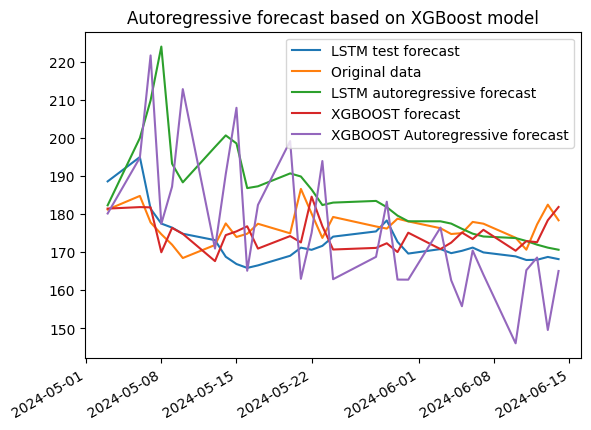

In [ ]:


y_pred_df['XGBOOST Autoregressive forecast']=xgboost_autoreg_forecast
y_pred_df.plot()
plt.title('Autoregressive forecast based on XGBoost model')
plt.legend()
plt.show()

In [ ]:
mape_xgb_autoreg = calculate_mape(y_pred_df['Original data'], y_pred_df['XGBOOST Autoregressive forecast'])

print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_autoreg:.2f}%")

Mean Absolute Percentage Error (MAPE): 8.61%


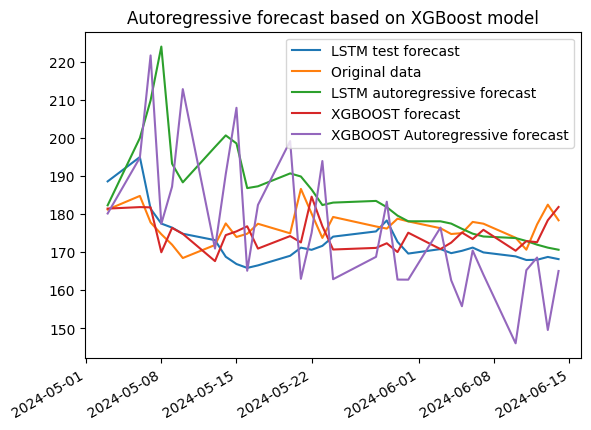

In [ ]:

y_pred_df.plot()
plt.title('Autoregressive forecast based on XGBoost model')
plt.legend()
plt.show()

In [ ]:
mape_xgb_autoreg = calculate_mape(y_pred_df['Original data'], y_pred_df['XGBOOST Autoregressive forecast'])

print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_autoreg:.2f}%")


Mean Absolute Percentage Error (MAPE): 8.61%


## Create autoregressive forecast for the next 30 days using LSTM and XGboost models. Compare results

In [ ]:
n_forecast_steps = 60  # Number of steps to forecast

# LSTM autoregressive forecast
lstm_predictions = autoregressive_forecast(lstm_model, X_test[-1], n_forecast_steps,sc_extra[target_col] )
#autoregressive_forecast(lstm_model, X_test, n_forecast_steps)
# Inverse transform the predictions to get the actual values
#lstm_predictions = sc_extra[target_col].inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()

# XGBoost autoregressive forecast
xgb_predictions = xgboost_autoregressive_forecast(xgb_model, X_test[-1], n_forecast_steps, sc_extra[target_col], target_col, extra_features, n_lags)

#autoregressive_forecast_xgboost(xgb_model, X_test_df, n_forecast_steps)
# Inverse transform the predictions to get the actual values
#xgb_predictions = sc_extra[target_col].inverse_transform(xgb_predictions.reshape(-1, 1)).flatten()


1/1 [==============================] - 0s 28ms/step


In [ ]:
# Getting date range for prediction
start_date=stock_price.index[-1]

# Generate a range of 30 business days starting from the last date in the stock_price index
business_days = pd.bdate_range(start=start_date, periods=n_forecast_steps)

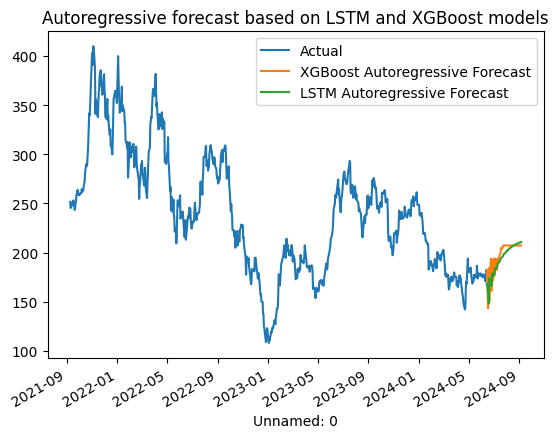

In [ ]:
stock_price['Close'].plot(label='Actual')

pd.Series(xgb_predictions, index=business_days).plot(label='XGBoost Autoregressive Forecast').plot()
pd.Series(lstm_predictions, index=business_days).plot(label='LSTM Autoregressive Forecast').plot()
plt.title('Autoregressive forecast based on LSTM and XGBoost models')
plt.legend()
plt.show()